In [1]:
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from stop_words import get_stop_words
from natasha import MorphVocab, NamesExtractor
from transformers import pipeline, AutoTokenizer
from nltk.tokenize import sent_tokenize

russian_stop_words = get_stop_words('ru')
morph_vocab = MorphVocab()
extractor = NamesExtractor(morph_vocab)
sentiment_analyzer = pipeline("sentiment-analysis", model="blanchefort/rubert-base-cased-sentiment")

/Users/vldlbnv/Python/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0


# Загрузим текст 12 стульев

In [2]:
with open('Ильфипетров_12 стульев.txt', 'r') as file:
    ilf_text = file.read()
ilf_chapters = [chapter.strip() for chapter in re.split(r'ГЛАВА[^\n]*\n', ilf_text)[1:]] # делим на главы


# Загрузим текст Булгакова "Белая гвардия"

In [3]:
with open('Булгаков_Белая гвардия.txt', 'r') as file:
    bulg_text = file.read()
bulg_chapters = [chapter.strip() for chapter in re.split(r'\x14\d+\x15\n', bulg_text)[1:]] # делим на главы


# Подготовим все нужные функции 

In [4]:
def count_sentences(chapters):
    sentences = sum([len(re.split(r'[.!?]', chapter)) for chapter in chapters]) // len(chapters)
    return sentences

def count_average_words(chapters):
    average_word_count = sum([len(re.sub(r'[^\w\s]', '', chapter).split()) for chapter in chapters]) // len(chapters)
    return average_word_count

def count_punctuation(chapters):
    punctuation = sum([len(re.findall(r'[^\w\s]', chapter)) for chapter in chapters]) // len(chapters)
    return punctuation

def count_vowels(chapters):
    vowels = sum([len(re.findall(r'[аеёиоуыэюяАЕЁИОУЫЭЮЯ]', chapter)) for chapter in chapters]) // len(chapters)
    return vowels

def count_consonants(chapters):
    consonants = sum([len(re.findall(r'[бвгджзйклмнпрстфхцчшщБВГДЖЗЙКЛМНПРСТФХЦЧШЩ]', chapter)) for chapter in chapters]) // len(chapters)
    return consonants

def average_word_length(text):
    words = re.findall(r'\b\w+\b', text)
    total_characters = sum(len(word) for word in words)
    average_length = total_characters / len(words)
    return average_length

def analyze_text(text, chapters):
    sentences = count_sentences(chapters)
    words = count_average_words(chapters)
    punctuation = count_punctuation(chapters)
    vowels = count_vowels(chapters)
    consonants = count_consonants(chapters)
    word_length = average_word_length(text)
    return {
        'sentences': sentences,
        'words': words,
        'punctuation': punctuation,
        'vowels': vowels,
        'consonants': consonants,
        'word_length': word_length
    }
    
def lemmatize_text(text):
    lemmatized_words = []
    for word in text.split():
        parse = morph_vocab.parse(word)
        if parse:
            lemmatized_word = parse[0].normal_form
            lemmatized_words.append(lemmatized_word)
    return ' '.join(lemmatized_words)



def remove_proper_nouns(text):
    matches = extractor(text)
    proper_nouns = set()

    for match in matches:
        if match.fact.first:
            proper_nouns.add(match.fact.first)
        if match.fact.last:
            proper_nouns.add(match.fact.last)
        if match.fact.middle:
            proper_nouns.add(match.fact.middle)

    words = re.findall(r'\b\w+\b', text)

    filtered_words = [word for word in words if word not in proper_nouns]
    
    return ' '.join(filtered_words)


def analyze_sentiment(text, model_name="blanchefort/rubert-base-cased-sentiment", max_tokens=500):
    sentiment_analyzer = pipeline("sentiment-analysis", model=model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def split_text_by_tokens(text, max_tokens):
        tokens = tokenizer.tokenize(text)
        chunks = []
        current_chunk = []

        for token in tokens:
            current_chunk.append(token)
            if len(current_chunk) >= max_tokens:
                chunks.append(tokenizer.convert_tokens_to_string(current_chunk))
                current_chunk = []

        if current_chunk:
            chunks.append(tokenizer.convert_tokens_to_string(current_chunk))

        return chunks

    text_chunks = split_text_by_tokens(text, max_tokens)

    sentiments = []
    for chunk in text_chunks:
        result = sentiment_analyzer(chunk)
        label = result[0]['label']
        if label == 'NEGATIVE':
            sentiment_value = -1
        elif label == 'NEUTRAL':
            sentiment_value = 0
        else:
            sentiment_value = 1
        sentiments.append(sentiment_value)

    if sentiments:
        average_sentiment = sum(sentiments) / len(sentiments)
    else:
        average_sentiment = 0

    return average_sentiment

# Посчитаем все для 12 стульев и Булгакова

In [5]:
ilf_data = analyze_text(ilf_text, ilf_chapters)
bulg_data = analyze_text(bulg_text, bulg_chapters)
print(ilf_data, bulg_data)

{'sentences': 264, 'words': 1962, 'punctuation': 636, 'vowels': 4610, 'consonants': 6220, 'word_length': 5.569047079841977} {'sentences': 536, 'words': 3534, 'punctuation': 1321, 'vowels': 7847, 'consonants': 10574, 'word_length': 5.2224030263835}


# Визуализации

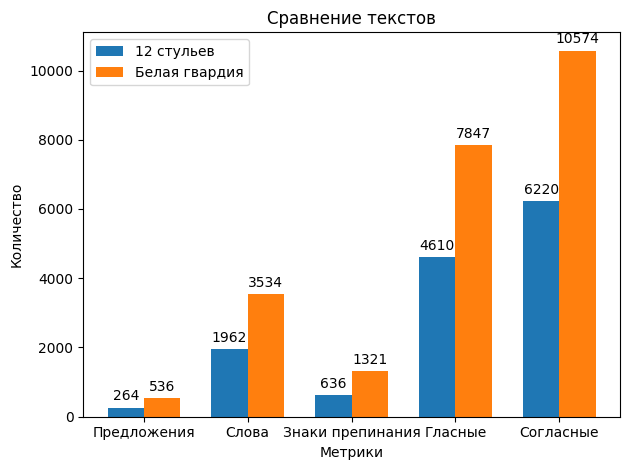

In [6]:
labels = ['Предложения', 'Слова', 'Знаки препинания', 'Гласные', 'Согласные']
ilf_values = [ilf_data['sentences'], ilf_data['words'], ilf_data['punctuation'], ilf_data['vowels'], ilf_data['consonants']]
bulg_values = [bulg_data['sentences'], bulg_data['words'], bulg_data['punctuation'], bulg_data['vowels'], bulg_data['consonants']]

# Создаем график
x = range(len(labels))  # Позиции меток на оси X
width = 0.35  # Ширина столбцов

fig, ax = plt.subplots()
rects1 = ax.bar([i - width/2 for i in x], ilf_values, width, label='12 стульев')
rects2 = ax.bar([i + width/2 for i in x], bulg_values, width, label='Белая гвардия')

# Добавляем подписи
ax.set_xlabel('Метрики')
ax.set_ylabel('Количество')
ax.set_title('Сравнение текстов')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Добавляем значения на столбцы
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Смещение текста
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Показываем график
plt.tight_layout()
plt.show()

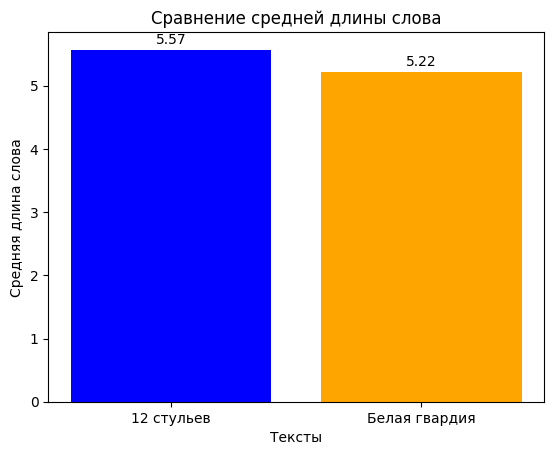

In [7]:
labels = ['12 стульев', 'Белая гвардия']
values = [ilf_data['word_length'], bulg_data['word_length']]

plt.bar(labels, values, color=['blue', 'orange'])


plt.xlabel('Тексты')
plt.ylabel('Средняя длина слова')
plt.title('Сравнение средней длины слова')

   
for i, value in enumerate(values):
    plt.text(i, value + 0.1, f'{value:.2f}', ha='center')

   
plt.show()

# Можно заметить, что по всем количественным показателям, кроме средней длины слова, Белая гвардия значительно превосходит 12 стульев

# Попробуем подготовить тексты для корректного отображения облаков слов. Лемматизируем их и уберем имена собственные с помощью библиотеки Natasha

In [8]:
prepared_ilf = remove_proper_nouns(ilf_text)
prepared_ilf = lemmatize_text(prepared_ilf)
prepared_bulg = remove_proper_nouns(bulg_text)
prepared_bulg = lemmatize_text(prepared_bulg)

ilf_wordcloud = WordCloud(
    width=800,              
    height=400,              
    colormap='viridis',     
    font_path=None,         
    stopwords=russian_stop_words,         
).generate(prepared_ilf)

bulg_wordcloud = WordCloud(
    width=800,              
    height=400,             
    colormap='viridis',     
    font_path=None,         
    stopwords=russian_stop_words,         
).generate(prepared_bulg)

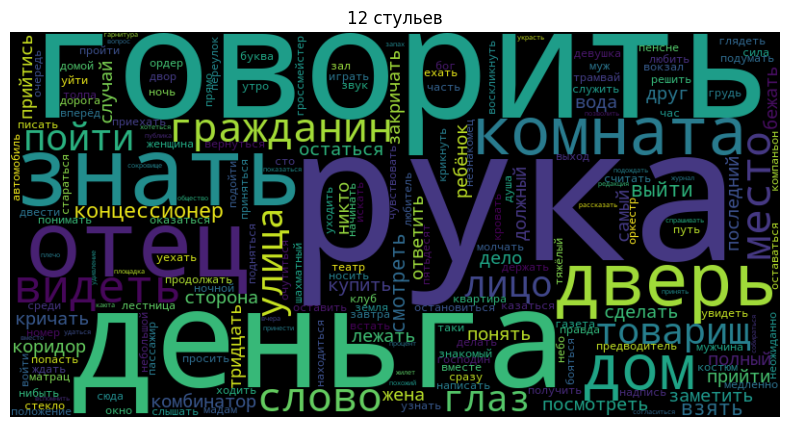

In [9]:
plt.figure(figsize=(10, 5))  
plt.imshow(ilf_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('12 стульев')  
plt.show()

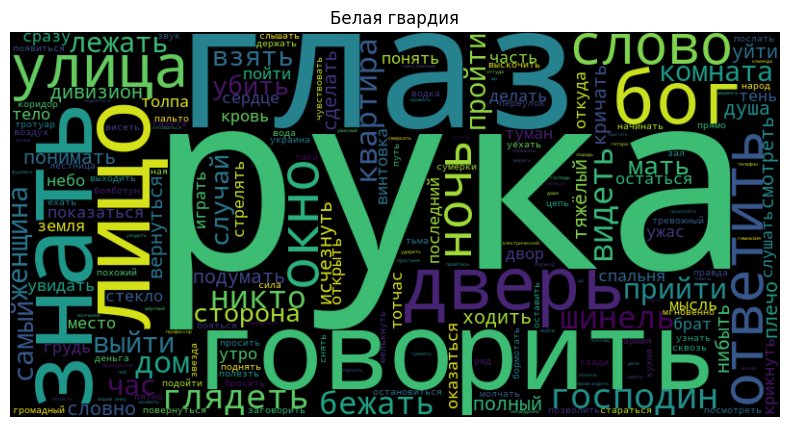

In [10]:
plt.figure(figsize=(10, 5))  
plt.imshow(bulg_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Белая гвардия')  
plt.show()

# Сначала результаты не получились, потому что функция, убирающая имена людей, работала неправильно и в вордклауде отображались Елены и Николеньки. Поэтому я поискал простой и быстрый способ их убрать и пришел к тому, что можно убрать все слова, начинающиеся с большой буквы. Из интереса оставил этот вариант ниже

In [11]:
prepared_ilf = re.sub(r'\b[А-ЯЁ][а-яё]*\b', '', ilf_text)
prepared_ilf = lemmatize_text(prepared_ilf)
prepared_bulg = re.sub(r'\b[А-ЯЁ][а-яё]*\b', '', bulg_text)
prepared_bulg = lemmatize_text(prepared_bulg)

ilf_wordcloud = WordCloud(
    width=800,              
    height=400, 
    colormap='viridis',     
    font_path=None,         
    stopwords=russian_stop_words,         
).generate(prepared_ilf)

bulg_wordcloud = WordCloud(
    width=800,              
    height=400, 
    colormap='viridis',     
    font_path=None,         
    stopwords=russian_stop_words,         
).generate(prepared_bulg)

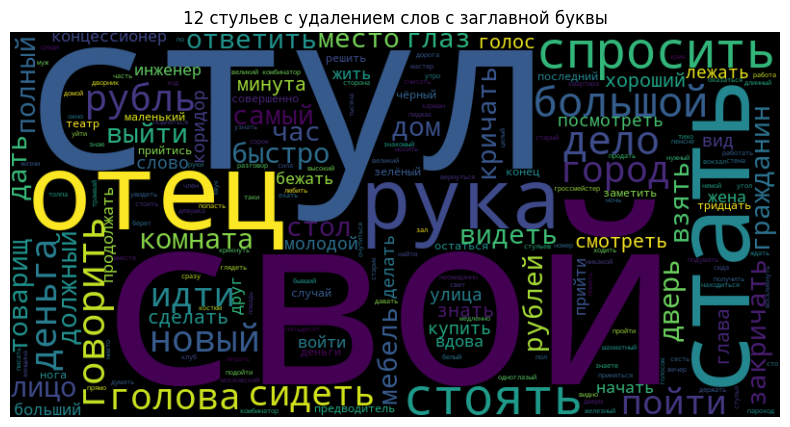

In [12]:
plt.figure(figsize=(10, 5))  
plt.imshow(ilf_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('12 стульев с удалением слов с заглавной буквы')  
plt.show()

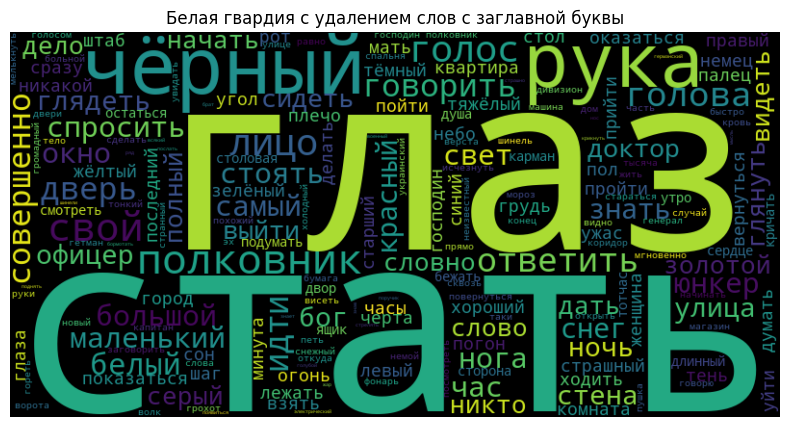

In [13]:
plt.figure(figsize=(10, 5))  
plt.imshow(bulg_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Белая гвардия с удалением слов с заглавной буквы')  
plt.show()

# Сравним тональности текстов

In [14]:
ilf_sentiment = analyze_sentiment(ilf_text)
bulg_sentiment = analyze_sentiment(bulg_text)

Device set to use mps:0
Device set to use mps:0


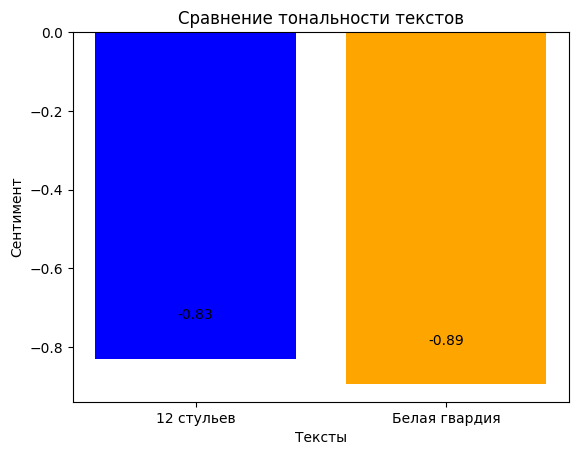

In [15]:
labels = ['12 стульев', 'Белая гвардия']
values = [ilf_sentiment, bulg_sentiment]

plt.bar(labels, values, color=['blue', 'orange'])


plt.xlabel('Тексты')
plt.ylabel('Сентимент')
plt.title('Сравнение тональности текстов')

   
for i, value in enumerate(values):
    plt.text(i, value + 0.1, f'{value:.2f}', ha='center')

   
plt.show()

In [16]:
print(ilf_sentiment, bulg_sentiment)

-0.8294573643410853 -0.8945147679324894


# Я использовал несколько моделей (DeepPavlov/rubert-base-cased-conversational и еще какую-то на основе Руберт) и самые разные вариации функций для анализа сентимента, но результаты были либо схожие, либо странные. По всей видимости, тексты либо и правда очень негативные, либо модель не справляется с тональностью текста столетней давности. В любом случае, тональности текстов похожие

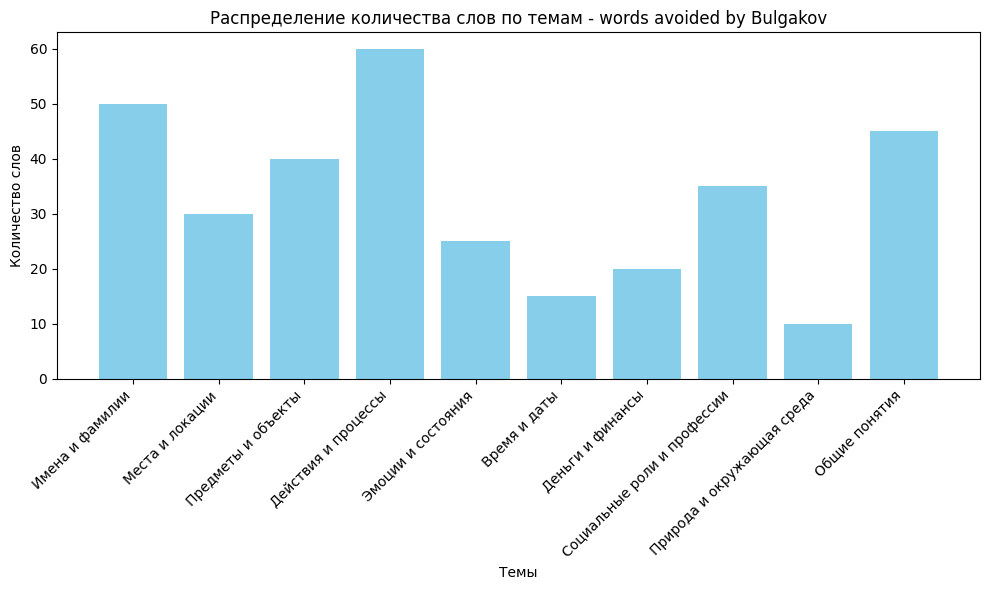

In [18]:
import matplotlib.pyplot as plt

# Данные
темы = [
    "Имена и фамилии", "Места и локации", "Предметы и объекты", 
    "Действия и процессы", "Эмоции и состояния", "Время и даты", 
    "Деньги и финансы", "Социальные роли и профессии", 
    "Природа и окружающая среда", "Общие понятия"
]
количество_слов = [50, 30, 40, 60, 25, 15, 20, 35, 10, 45]

# Построение диаграммы
plt.figure(figsize=(10, 6))
plt.bar(темы, количество_слов, color='skyblue')
plt.xlabel('Темы')
plt.ylabel('Количество слов')
plt.title('Распределение количества слов по темам - words avoided by Bulgakov')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [28]:
def analyze_small_sentiment(text, model_name="blanchefort/rubert-base-cased-sentiment", max_tokens=1):
    sentiment_analyzer = pipeline("sentiment-analysis", model=model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def split_text_by_tokens(text, max_tokens):
        tokens = tokenizer.tokenize(text)
        chunks = []
        current_chunk = []

        for token in tokens:
            current_chunk.append(token)
            if len(current_chunk) >= max_tokens:
                chunks.append(tokenizer.convert_tokens_to_string(current_chunk))
                current_chunk = []

        if current_chunk:
            chunks.append(tokenizer.convert_tokens_to_string(current_chunk))

        return chunks

    text_chunks = split_text_by_tokens(text, max_tokens)

    sentiments = []
    for chunk in text_chunks:
        result = sentiment_analyzer(chunk)
        label = result[0]['label']
        if label == 'NEGATIVE':
            sentiment_value = -1
        elif label == 'NEUTRAL':
            sentiment_value = 0
        else:
            sentiment_value = 1
        sentiments.append(sentiment_value)

    if sentiments:
        average_sentiment = sum(sentiments) / len(sentiments)
    else:
        average_sentiment = 0

    return average_sentiment

In [29]:
with open('/Users/vldlbnv/Магистратура/1 курс/модуль 3/Прикладная лингвистика/words_preferred.txt') as file:
    text_bulg = file.read()
    sentiment_preferred_bulg = analyze_small_sentiment(text_bulg)
print(sentiment_preferred_bulg)

Device set to use mps:0


-0.052873563218390804


In [30]:
with open('/Users/vldlbnv/Магистратура/1 курс/модуль 3/Прикладная лингвистика/words_avoided.txt') as file:
    text_ilf = file.read()
    sentiment_preferred_ilf = analyze_small_sentiment(text_ilf)
print(sentiment_preferred_ilf)

Device set to use mps:0


-0.023586823912159414


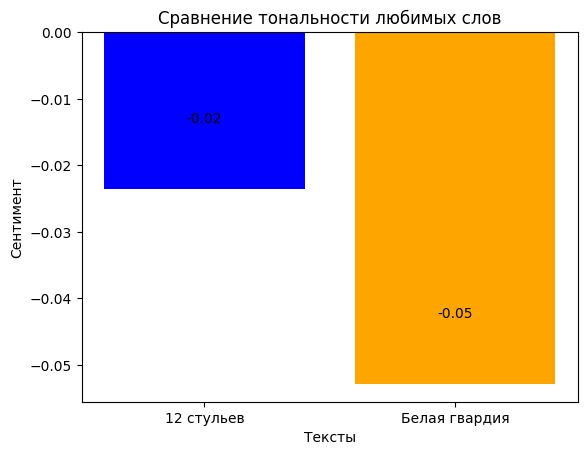

In [32]:
labels = ['12 стульев', 'Белая гвардия']
values = [sentiment_preferred_ilf, sentiment_preferred_bulg]

plt.bar(labels, values, color=['blue', 'orange'])


plt.xlabel('Тексты')
plt.ylabel('Сентимент')
plt.title('Сравнение тональности любимых слов')

   
for i, value in enumerate(values):
    plt.text(i, value + 0.01, f'{value:.2f}', ha='center')

   
plt.show()